# Scenario 1 with 2 regimes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wishart, norm
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import GaussianHMM
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data Generation

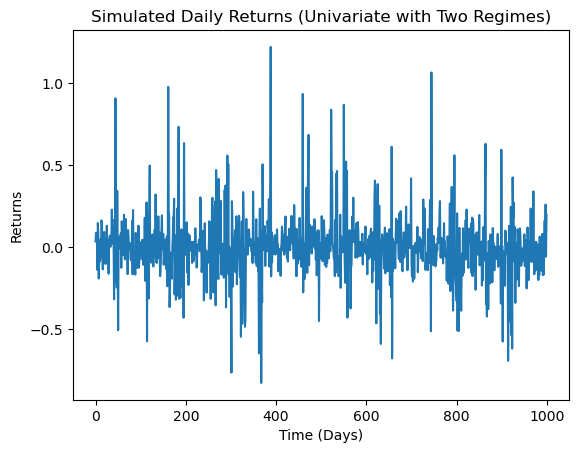

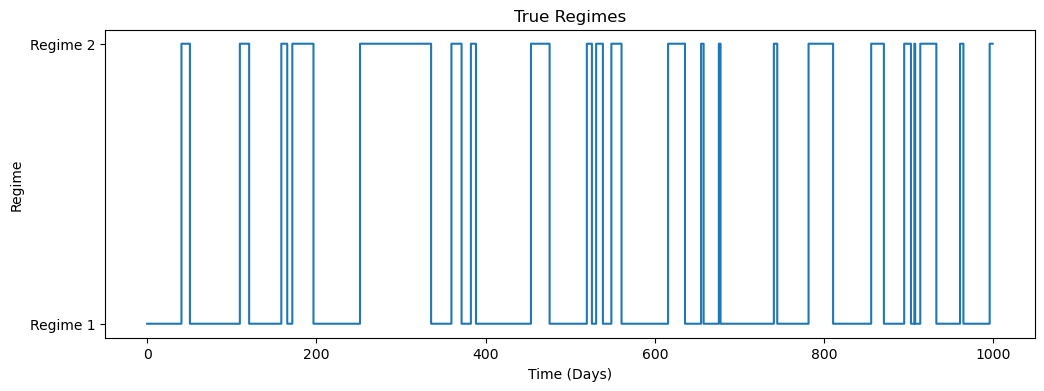

In [53]:
np.random.seed(1)

# Step 1: Define the Transition Matrix Q for two regimes
Q = np.array([[0.97, 0.03],
              [0.06, 0.94]])

# Step 2: Generate State Sequence (ht) for 500 daily data points
def generate_states(T, Q):
    states = [0]  # Start with the first regime
    for t in range(1, T):
        current_state = states[-1]
        next_state = np.random.choice([0, 1], p=Q[current_state])
        states.append(next_state)
    return np.array(states)

T = 1000  # Total number of days
states = generate_states(T, Q)

# Step 3: Define Variances for Each Regime (2 regimes)
# Since this is now univariate with two regimes, we define variance for each regime
variances = {
    0: 0.01,  # Low volatility regime
    1: 0.10   # High volatility regime
}

# Step 4: Generate Daily Variances Using Chi-Square Distribution
daily_variances = []

for t in range(T):
    variance_t = variances[states[t]]
    sampled_variance = variance_t * (np.random.chisquare(df=5) / 5)  # Scale by chi-square to add randomness
    daily_variances.append(sampled_variance)

# Step 5: Generate Daily Returns
daily_returns = []

for t in range(T):
    variance_t = daily_variances[t]
    return_t = norm.rvs(loc=0, scale=np.sqrt(variance_t))  # Univariate normal distribution
    daily_returns.append(return_t)

daily_returns = np.array(daily_returns)

# Visualizing the simulated univariate returns
plt.plot(daily_returns)  # Plotting the returns
plt.title("Simulated Daily Returns (Univariate with Two Regimes)")
plt.xlabel("Time (Days)")
plt.ylabel("Returns")
plt.show()

# Visualizing the regime states (True States)
plt.figure(figsize=(12, 4))
plt.step(range(T), states, where='mid')
plt.title("True Regimes")
plt.xlabel("Time (Days)")
plt.ylabel("Regime")
plt.yticks([0, 1], ['Regime 1', 'Regime 2'])
plt.show()


In [4]:
daily_returns = pd.DataFrame({
    'Returns': daily_returns,
    'State': states
})

In [5]:
daily_returns.sample(10)

,Returns,State
993,-0.167524,0
650,-0.077681,0
39,0.125525,0
92,-0.126769,0
14,0.141644,0
451,-0.075803,0
985,-0.139873,0
576,-0.064246,0
925,0.173967,1
516,0.019904,0


In [6]:
# train_test_split
train_size = int(0.8 * len(daily_returns))
train_df = daily_returns[:train_size]
test_df = daily_returns[train_size:]

In [7]:
returns = pd.DataFrame(train_df['Returns'])

In [8]:
train_returns_series = returns['Returns']

# Ensure test_returns is numeric
train_returns_series = pd.to_numeric(train_returns_series, errors='coerce')

# Step 1: Reconstruct actual test prices from test returns
initial_price = 1  # You can set this to any value or the last known price from the training data
train_prices = [initial_price]

# Loop through the test returns and calculate the price at each step
for ret in train_returns_series:
    next_price = train_prices[-1] * (1 + ret)
    train_prices.append(next_price)

# Remove the initial price from the list to keep only the predicted prices
train_prices = train_prices[1:]

In [59]:
train_prices[-1]

0.0005662154078002329

## Hidden Markov Model (HMM)

C:\Users\uditi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


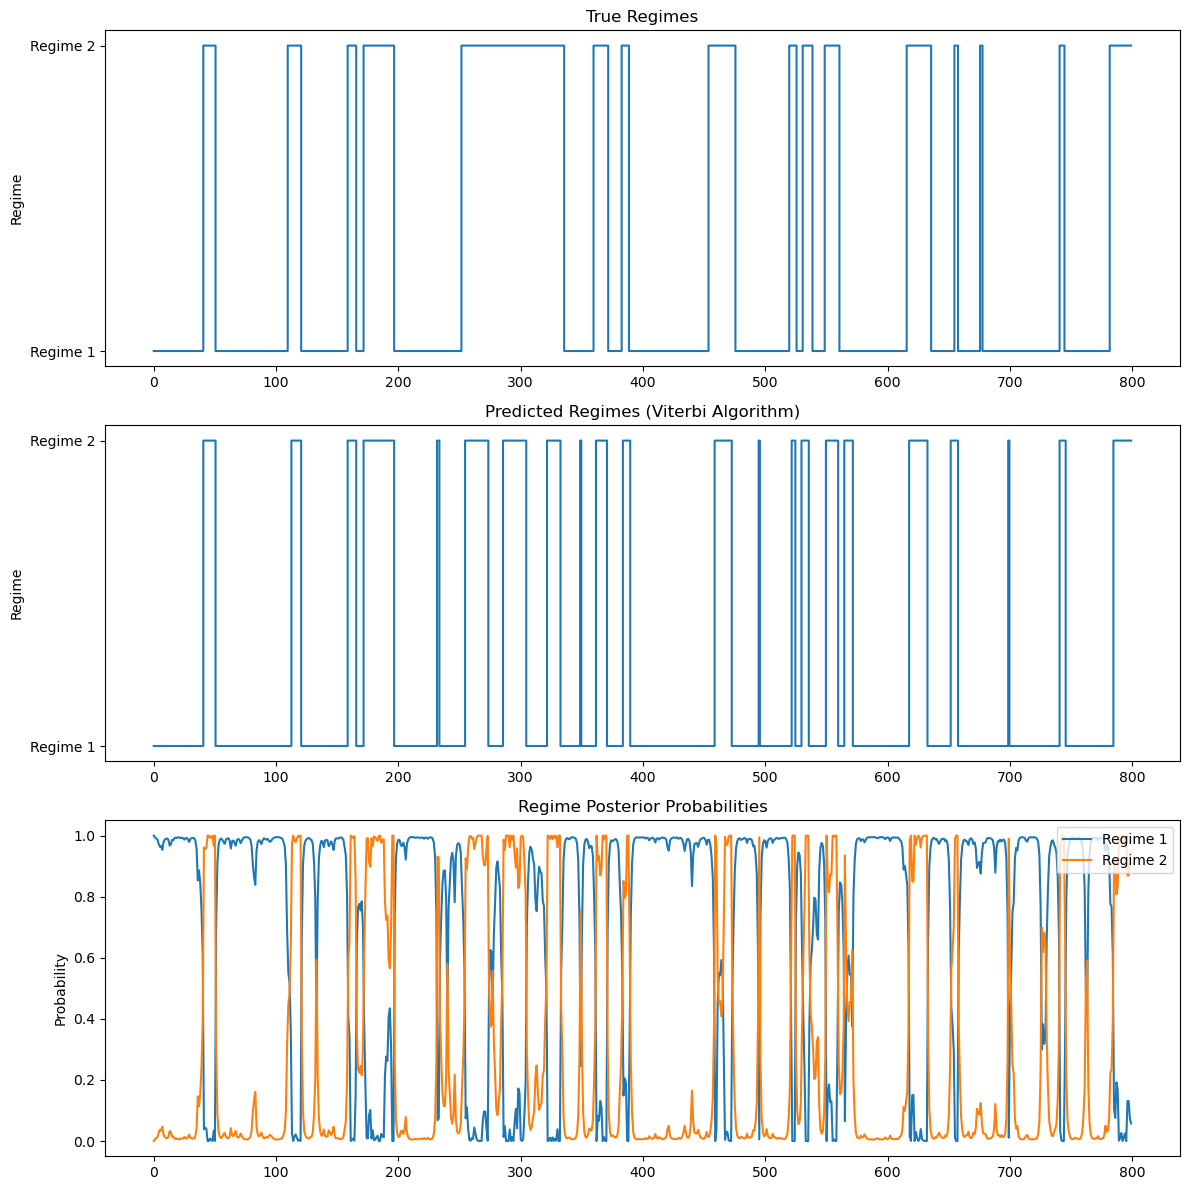

Transition matrix
[[0.94188999 0.05811001]
 [0.13992303 0.86007697]]

Means and variances of each hidden state

Hidden state 1
Mean = [-0.00087963]
Variance = [0.00880792]

Hidden state 2
Mean = [0.03789909]
Variance = [0.10984237]


In [10]:
# Step 2: Fit the HMM
model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000, random_state=42)
model.fit(returns)

# Step 3: Use the Viterbi Algorithm to find the most likely sequence of hidden states
most_likely_states = model.predict(returns)

# Step 4: Calculate the posterior probabilities
posterior_probs = model.predict_proba(returns)

# Step 5: Plot the true regimes, the most likely states from Viterbi, and the posterior probabilities
fig, axs = plt.subplots(3, figsize=(12, 12))

# Plot the true regimes
axs[0].step(range(len(train_df['State'])), train_df['State'], where='mid', label='True Regimes')
axs[0].set_title('True Regimes')
axs[0].set_ylabel('Regime')
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(['Regime 1', 'Regime 2'])

# Plot the most likely states from Viterbi
axs[1].step(range(len(most_likely_states)), most_likely_states, where='mid', label='Predicted Regimes')
axs[1].set_title('Predicted Regimes (Viterbi Algorithm)')
axs[1].set_ylabel('Regime')
axs[1].set_yticks([0, 1])
axs[1].set_yticklabels(['Regime 1', 'Regime 2'])

# Plot the posterior probabilities
axs[2].plot(posterior_probs)
axs[2].set_title('Regime Posterior Probabilities')
axs[2].set_ylabel('Probability')
axs[2].legend(['Regime 1', 'Regime 2'], loc='upper right')

plt.tight_layout()
plt.show()

# Print the transition matrix and other model information
print("Transition matrix")
print(model.transmat_)

print("\nMeans and variances of each hidden state")
for i in range(model.n_components):
    print(f"\nHidden state {i + 1}")
    print(f"Mean = {model.means_[i]}")
    print(f"Variance = {model.covars_[i][0]}")  # Since it's univariate, the covariance is just a variance value


In [11]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate the confusion matrix
cm = confusion_matrix(train_df['State'], most_likely_states)
print("Confusion Matrix:")
print(cm)

# Generate the classification report (includes precision, recall, F1-score)
print("\nClassification Report for HMM:")
print(classification_report(train_df['State'], most_likely_states, target_names=['Regime 1', 'Regime 2']))


Confusion Matrix:
[[532  18]
 [ 68 182]]

Classification Report for HMM:
              precision    recall  f1-score   support

    Regime 1       0.89      0.97      0.93       550
    Regime 2       0.91      0.73      0.81       250

    accuracy                           0.89       800
   macro avg       0.90      0.85      0.87       800
weighted avg       0.89      0.89      0.89       800



In [12]:
# PREDICTIONS

In [13]:
test_returns = pd.DataFrame(test_df['Returns'])

In [14]:
type(test_returns)

pandas.core.frame.DataFrame

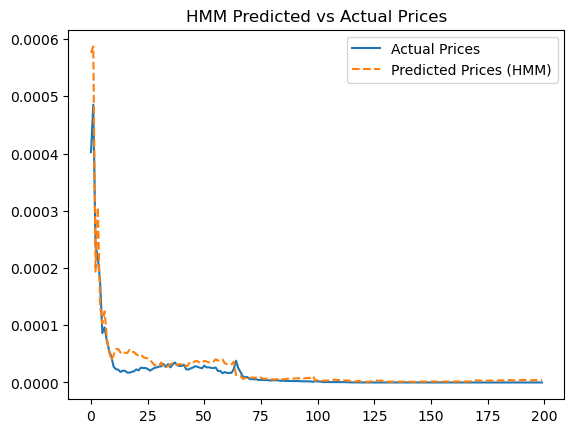

In [63]:
# Ensure we're working with a single column, e.g., 'Returns'
# If 'Returns' is the column containing your data in the test_returns DataFrame
test_returns_series = test_returns['Returns']

# Ensure test_returns is numeric
test_returns_series = pd.to_numeric(test_returns_series, errors='coerce')

# Step 1: Reconstruct actual test prices from test returns
initial_price = 0.0006  # the last known price from the training data
test_prices = [initial_price]

# Loop through the test returns and calculate the price at each step
for ret in test_returns_series:
    next_price = test_prices[-1] * (1 + ret)
    test_prices.append(next_price)

# Remove the initial price from the list to keep only the predicted prices
test_prices = test_prices[1:]

test_returns_series = np.array(test_returns_series).reshape(-1,1)
predicted_states_test = model.predict(test_returns_series)

np.random.seed(2)
# Step 2: Predict returns based on the state means and variances
predicted_test_returns = []
for state in predicted_states_test:
    mean_return = model.means_[state][0]  # Extract the mean for the state
    variance_return = model.covars_[state][0][0]  # Extract the variance for the state
    predicted_return = np.random.normal(loc=mean_return, scale=np.sqrt(variance_return))
    predicted_test_returns.append(predicted_return)

# Step 3: Convert predicted returns to predicted prices
predicted_test_prices = [initial_price]

for ret in predicted_test_returns:
    next_price = predicted_test_prices[-1] * (1 + ret)
    predicted_test_prices.append(next_price)

predicted_test_prices = predicted_test_prices[1:]  # Remove initial price
test_indices = range(len(test_returns))

# Plot Actual vs Predicted Prices
plt.plot(test_indices, test_prices, label='Actual Prices')
plt.plot(test_indices, predicted_test_prices, label='Predicted Prices (HMM)', linestyle='--')
plt.title('HMM Predicted vs Actual Prices')
plt.legend()
plt.show()

In [110]:
test_prices = np.array(test_prices)
predicted_test_prices = np.array(predicted_test_prices)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(test_prices, predicted_test_prices)

# Mean Squared Error (MSE)
mse = mean_squared_error(test_prices, predicted_test_prices)
rmse = mse **(1/2)

# Mean Absolute Percentage Error (MAPE)
epsilon = 1e-1
mape = np.mean(np.abs((test_prices - predicted_test_prices) / (test_prices + epsilon))) * 100

# Display the metrics
print(f"MAE (Mean Absolute Error): {mae}")
print(f"RMSE (Root Mean Squared Error): {rmse}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

MAE (Mean Absolute Error): 8.677806860967701e-06
RMSE (Root Mean Squared Error): 1.9192491126193565e-05
MAPE (Mean Absolute Percentage Error): 0.01%


## Gaussian Mixture Model (GMM)

C:\Users\uditi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


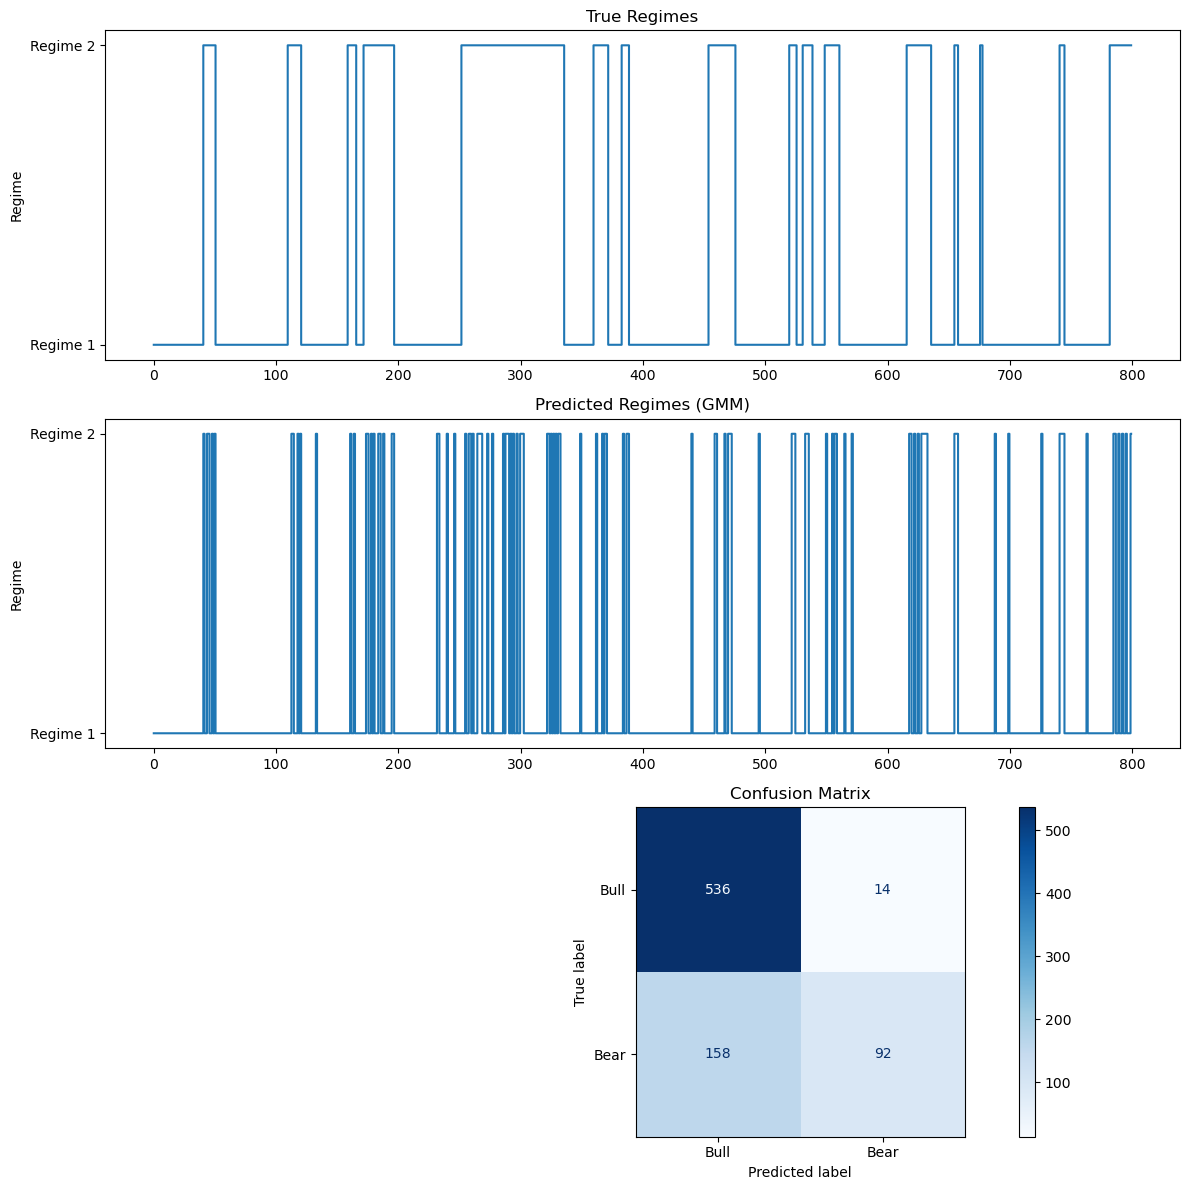

GMM Means and Variances for each hidden state:

Hidden state 1
Mean = -0.004257871104531613
Variance = [[0.01136153]]

Hidden state 2
Mean = 0.06862126829039891
Variance = [[0.14157023]]


In [68]:
# Step 1: Fit the GMM model
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=1)
gmm.fit(returns)

# Step 2: Predict the regimes using GMM
gmm_labels = gmm.predict(returns)

# Step 3: Plot the true regimes, GMM-predicted regimes, and the confusion matrix

fig, axs = plt.subplots(3, figsize=(12, 12))

# Plot the true regimes
axs[0].step(range(len(train_df['State'])), train_df['State'], where='mid', label='True Regimes')
axs[0].set_title('True Regimes')
axs[0].set_ylabel('Regime')
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(['Regime 1', 'Regime 2'])

# Plot the predicted regimes by GMM
axs[1].step(range(len(gmm_labels)), gmm_labels, where='mid', label='Predicted Regimes')
axs[1].set_title('Predicted Regimes (GMM)')
axs[1].set_ylabel('Regime')
axs[1].set_yticks([0, 1])
axs[1].set_yticklabels(['Regime 1', 'Regime 2'])

# Plot the confusion matrix
cm = confusion_matrix(train_df['State'], gmm_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bull', 'Bear'])
disp.plot(ax=axs[2], cmap='Blues')
axs[2].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

# Print GMM Means and Variances for each hidden state
print("GMM Means and Variances for each hidden state:")
for i in range(gmm.n_components):
    print(f"\nHidden state {i + 1}")
    print(f"Mean = {gmm.means_[i][0]}")
    print(f"Variance = {gmm.covariances_[i]}")  # Since it's univariate, covariance is just a variance value


In [69]:
# Generate the confusion matrix
cm = confusion_matrix(train_df['State'], gmm_labels)
print("Confusion Matrix:")
print(cm)

# Generate the classification report (includes precision, recall, F1-score)
print("\nClassification Report for GMM:")
print(classification_report(train_df['State'], gmm_labels, target_names=['Regime 1', 'Regime 2']))


Confusion Matrix:
[[536  14]
 [158  92]]

Classification Report for GMM:
              precision    recall  f1-score   support

    Regime 1       0.77      0.97      0.86       550
    Regime 2       0.87      0.37      0.52       250

    accuracy                           0.79       800
   macro avg       0.82      0.67      0.69       800
weighted avg       0.80      0.79      0.75       800



C:\Users\uditi\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


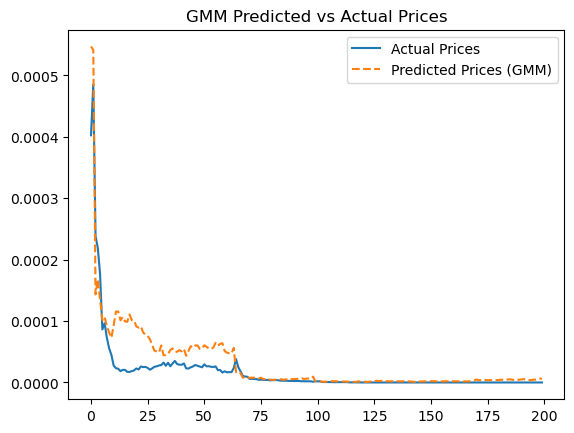

In [70]:
# Step 1: Predict the states for the test set using GMM
predicted_states_test_gmm = gmm.predict(test_returns_series.reshape(-1, 1))

# Step 2: Predict returns based on the GMM means and variances
predicted_test_returns_gmm = []
np.random.seed(2)

for state in predicted_states_test_gmm:
    mean_return = gmm.means_[state][0]  # Extract the mean for the state
    variance_return = np.diag(gmm.covariances_[state])[0]  # Extract the variance for the state
    predicted_return = np.random.normal(loc=mean_return, scale=np.sqrt(variance_return))
    predicted_test_returns_gmm.append(predicted_return)

# Step 3: Convert predicted returns to predicted prices
predicted_test_prices_gmm = [initial_price]  # You can set initial_price to match your previous initial condition

for ret in predicted_test_returns_gmm:
    next_price = predicted_test_prices_gmm[-1] * (1 + ret)
    predicted_test_prices_gmm.append(next_price)

# Remove initial price from the list
predicted_test_prices_gmm = predicted_test_prices_gmm[1:]

# Plot Actual vs Predicted Prices
test_indices = range(len(test_returns_series))

plt.plot(test_indices, test_prices, label='Actual Prices')
plt.plot(test_indices, predicted_test_prices_gmm, label='Predicted Prices (GMM)', linestyle='--')
plt.title('GMM Predicted vs Actual Prices')
plt.legend()
plt.show()

In [108]:
# Mean Absolute Error (MAE)
gmm_mae = mean_absolute_error(test_prices, predicted_test_prices_gmm)

# Mean Squared Error (MSE)
gmm_rmse = (mean_squared_error(test_prices, predicted_test_prices_gmm))**(1/2)


# Mean Absolute Percentage Error (MAPE)
epsilon = 1e-4
gmm_mape = np.mean(np.abs((test_prices - predicted_test_prices_gmm) / (test_prices + epsilon))) * 100

# Display the metrics
print(f"MAE (Mean Absolute Error): {gmm_mae}")
print(f"RMSE (Root Mean Squared Error): {gmm_rmse}")
print(f"MAPE (Mean Absolute Percentage Error): {gmm_mape:.2f}%")

MAE (Mean Absolute Error): 1.5783282006591295e-05
RMSE (Root Mean Squared Error): 2.90879962248892e-05
MAPE (Mean Absolute Percentage Error): 11.95%


# K-Means

C:\Users\uditi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


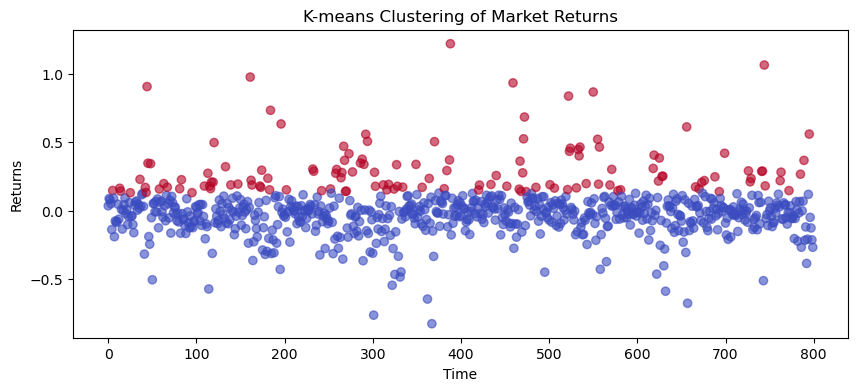

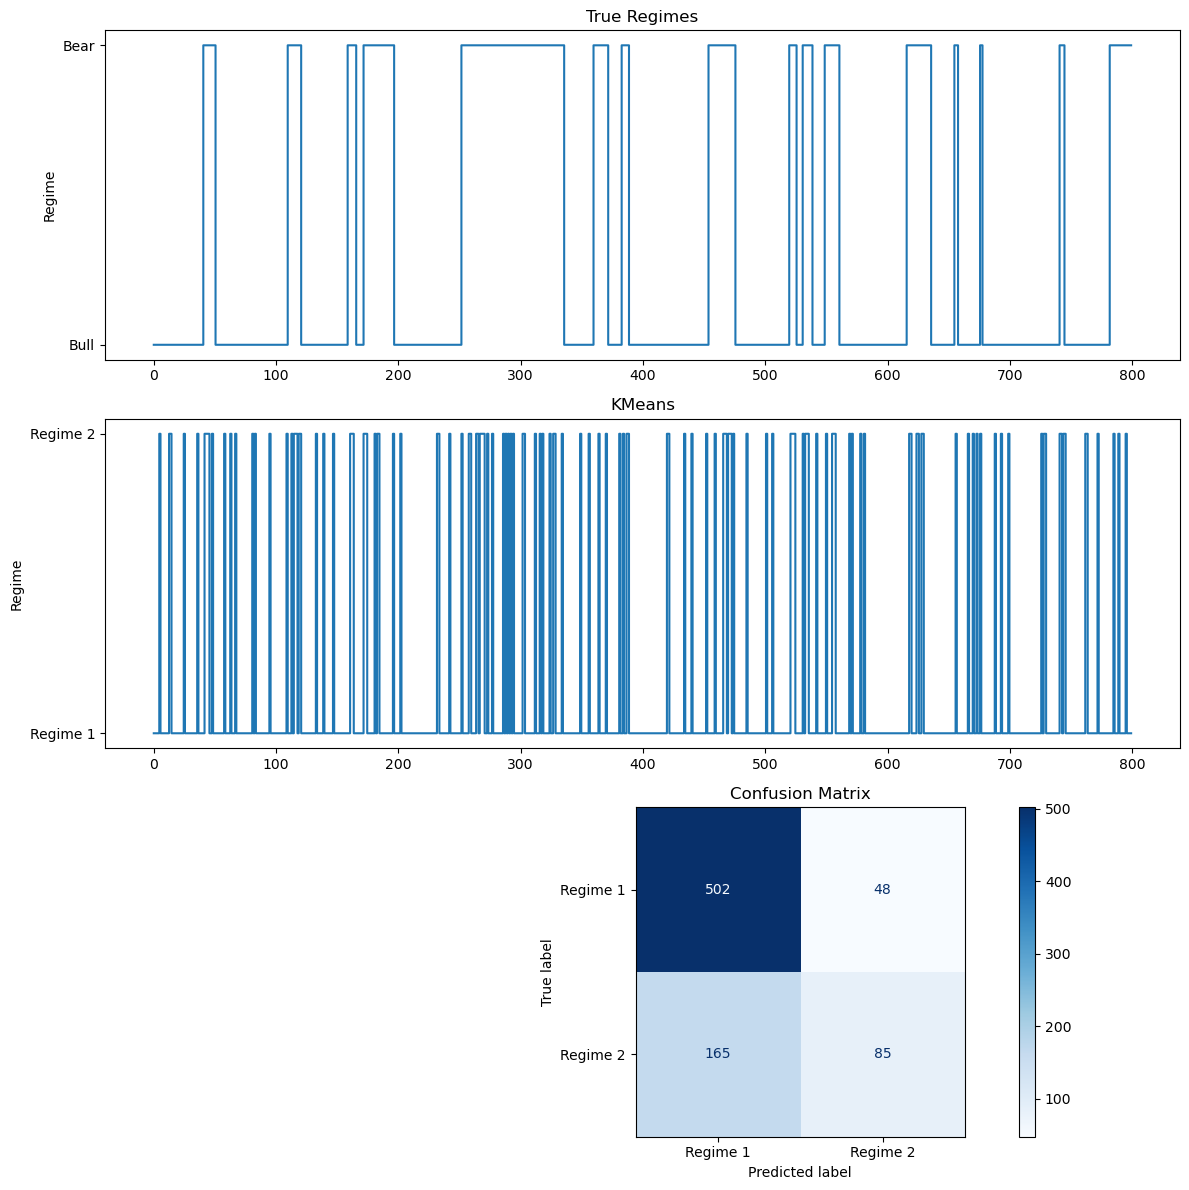

In [77]:
# Fit K-means with 2 clusters (bull and bear)
kmeans = KMeans(n_clusters=2, random_state=18)
kmeans.fit(returns)
kmeans_labels = kmeans.predict(returns)

# Plot K-means clusters
plt.figure(figsize=(10, 4))
#plt.plot(returns, label='Returns')
plt.scatter(range(len(returns)), returns, c=kmeans_labels, cmap='coolwarm', label='K-means Clusters', alpha=0.6)
plt.title('K-means Clustering of Market Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.show()

# Step 3: Plot the true regimes, Kmeans-predicted regimes, and the confusion matrix

fig, axs = plt.subplots(3, figsize=(12, 12))

# Plot the true regimes
axs[0].step(range(len(train_df['State'])), train_df['State'], where='mid', label='True Regimes')
axs[0].set_title('True Regimes')
axs[0].set_ylabel('Regime')
axs[0].set_yticks([0, 1])
axs[0].set_yticklabels(['Bull', 'Bear'])

# Plot the predicted regimes by Kmeans
axs[1].step(range(len(gmm_labels)), kmeans_labels, where='mid', label='Predicted Regimes')
axs[1].set_title('KMeans')
axs[1].set_ylabel('Regime')
axs[1].set_yticks([0, 1])
axs[1].set_yticklabels(['Regime 1', 'Regime 2'])

# Plot the confusion matrix
cm = confusion_matrix(train_df['State'], kmeans_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Regime 1', 'Regime 2'])
disp.plot(ax=axs[2], cmap='Blues')
axs[2].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()


In [78]:
# Generate the confusion matrix
cm = confusion_matrix(train_df['State'], kmeans_labels)
print("Confusion Matrix:")
print(cm)

# Generate the classification report (includes precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(train_df['State'], kmeans_labels, target_names=['Regime 1', 'Regime 2']))

Confusion Matrix:
[[502  48]
 [165  85]]

Classification Report:
              precision    recall  f1-score   support

    Regime 1       0.75      0.91      0.82       550
    Regime 2       0.64      0.34      0.44       250

    accuracy                           0.73       800
   macro avg       0.70      0.63      0.63       800
weighted avg       0.72      0.73      0.71       800



C:\Users\uditi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


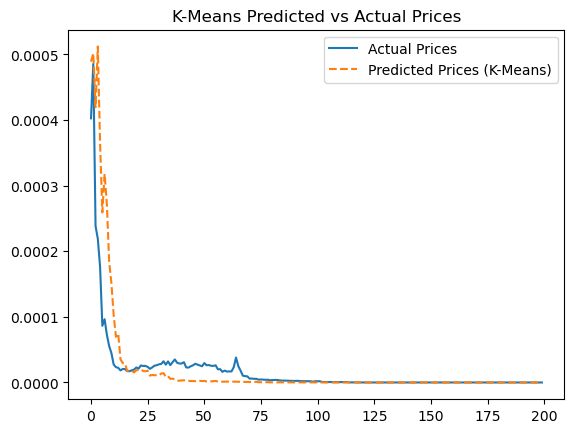

In [79]:
kmeans.fit(test_returns_series.reshape(-1, 1))

# Step 2: Predict the K-Means clusters (regimes) for the test data
predicted_states_test_kmeans = kmeans.predict(test_returns_series.reshape(-1, 1))

# Step 3: Predict returns based on the mean of each cluster
# You need to calculate the mean and variance of returns for each K-means cluster
mean_returns_kmeans = []
variance_returns_kmeans = []

for i in range(kmeans.n_clusters):
    cluster_returns = test_returns_series[kmeans.labels_ == i]
    mean_returns_kmeans.append(cluster_returns.mean())
    variance_returns_kmeans.append(cluster_returns.var())

# Predict returns based on the cluster means and variances
predicted_test_returns_kmeans = []
np.random.seed(42)

for state in predicted_states_test_kmeans:
    mean_return = mean_returns_kmeans[state]
    variance_return = variance_returns_kmeans[state]
    predicted_return = np.random.normal(loc=mean_return, scale=np.sqrt(variance_return))
    predicted_test_returns_kmeans.append(predicted_return)

# Step 4: Convert predicted returns to predicted prices
predicted_test_prices_kmeans = [initial_price]  # You can set this to match the last training price

for ret in predicted_test_returns_kmeans:
    next_price = predicted_test_prices_kmeans[-1] * (1 + ret)
    predicted_test_prices_kmeans.append(next_price)

predicted_test_prices_kmeans = predicted_test_prices_kmeans[1:]  # Remove the initial price

# Plot Actual vs Predicted Prices (K-Means)
test_indices = range(len(test_returns_series))

plt.plot(test_indices, test_prices, label='Actual Prices')
plt.plot(test_indices, predicted_test_prices_kmeans, label='Predicted Prices (K-Means)', linestyle='--')
plt.title('K-Means Predicted vs Actual Prices')
plt.legend()
plt.show()


In [106]:
# Mean Absolute Error (MAE)
kmeans_mae = mean_absolute_error(test_prices, predicted_test_prices_kmeans)

# Mean Squared Error (MSE)
kmeans_rmse = (mean_squared_error(test_prices, predicted_test_prices_kmeans))**(1/2)

# Mean Absolute Percentage Error (MAPE)
#epsilon = 1e-1
kmeans_mape = np.mean(np.abs((test_prices - predicted_test_prices_kmeans) / (test_prices))) * 100

# Display the metrics
print(f"MAE (Mean Absolute Error): {kmeans_mae}")
print(f"RMSE (Root Mean Squared Error): {kmeans_rmse}")
print(f"MAPE (Mean Absolute Percentage Error): {kmeans_mape:.2f}%")

MAE (Mean Absolute Error): 1.421679897680323e-05
RMSE (Root Mean Squared Error): 4.120331286109328e-05
MAPE (Mean Absolute Percentage Error): 74.41%
